Create and Art with Neural style transfer on given image using deep learning. 

Iteration 0: Total Loss=1542290409521152.00, Content Loss=0.00, Style Loss=1542290409521152.00
Iteration 10: Total Loss=318877665853440.00, Content Loss=5506.42, Style Loss=318877665853440.00
Iteration 20: Total Loss=190223967322112.00, Content Loss=6143.16, Style Loss=190223967322112.00
Iteration 30: Total Loss=139118310850560.00, Content Loss=6472.54, Style Loss=139118302461952.00
Iteration 40: Total Loss=106045728882688.00, Content Loss=6642.31, Style Loss=106045720494080.00
Iteration 50: Total Loss=82819955032064.00, Content Loss=6755.98, Style Loss=82819946643456.00
Iteration 60: Total Loss=66164575174656.00, Content Loss=6861.30, Style Loss=66164566786048.00
Iteration 70: Total Loss=53807333507072.00, Content Loss=6982.06, Style Loss=53807325118464.00
Iteration 80: Total Loss=44336339222528.00, Content Loss=7111.92, Style Loss=44336330833920.00
Iteration 90: Total Loss=36865293942784.00, Content Loss=7229.31, Style Loss=36865285554176.00


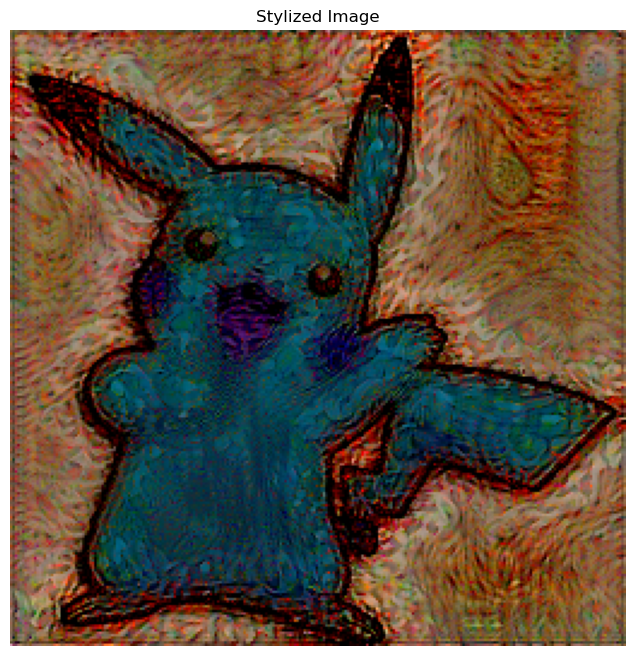

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import models
import PIL.Image as pil_image

# Global content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Load and preprocess image
def load_img(img_path, target_size=(256, 256)):
    img = pil_image.open(img_path).convert('RGB')
    img = img.resize(target_size, pil_image.LANCZOS)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Deprocess image for viewing
def deprocess_img(img):
    img = tf.squeeze(img, axis=0)
    img = img.numpy()
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Compute Gram matrix for style features
def gram_matrix(tensor):
    x = tf.squeeze(tensor, axis=0)
    x = tf.transpose(x, (2, 0, 1))  # Channels first
    features = tf.reshape(x, (x.shape[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# Load pretrained VGG19 and extract specific layers
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in content_layers + style_layers]
    return models.Model(inputs=vgg.input, outputs=outputs)

# Compute total loss
def compute_loss(model, loss_weights, generated_image, content_targets, style_targets):
    content_weight, style_weight = loss_weights
    model_outputs = model(generated_image)

    content_output = model_outputs[:len(content_layers)]
    style_output = model_outputs[len(content_layers):]

    # Content loss
    content_loss = tf.reduce_mean((content_output[0] - content_targets[0]) ** 2)

    # Style loss using Gram matrices
    style_loss = 0
    for output, target in zip(style_output, style_targets):
        gram_o = gram_matrix(output)
        style_loss += tf.reduce_mean((gram_o - target) ** 2)
    style_loss *= style_weight / len(style_layers)

    total_loss = content_weight * content_loss + style_loss
    return total_loss, content_loss, style_loss

# Run Neural Style Transfer
def run_style_transfer(content_path, style_path, iterations=100, content_weight=1e3, style_weight=1e-2):
    content_img = preprocess_input(load_img(content_path))
    style_img = preprocess_input(load_img(style_path))
    generated_img = tf.Variable(content_img, dtype=tf.float32)

    model = get_model()
    content_features = model(content_img)[:len(content_layers)]
    style_features = [gram_matrix(f) for f in model(style_img)[len(content_layers):]]

    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    @tf.function()
    def train_step():
        with tf.GradientTape() as tape:
            loss, c_loss, s_loss = compute_loss(model, (content_weight, style_weight), generated_img, content_features, style_features)
        grad = tape.gradient(loss, generated_img)
        optimizer.apply_gradients([(grad, generated_img)])
        return loss, c_loss, s_loss

    for i in range(iterations):
        loss, c_loss, s_loss = train_step()
        if i % 10 == 0:
            print(f"Iteration {i}: Total Loss={loss:.2f}, Content Loss={c_loss:.2f}, Style Loss={s_loss:.2f}")

    return deprocess_img(generated_img)

# ---- Run Style Transfer ----
content_path = 'c.jpg'
style_path = 'style.jpg'

output = run_style_transfer(content_path, style_path, iterations=100)

# Display result
plt.figure(figsize=(8, 8))
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Image")
plt.show()
